In [60]:
import numpy as np
import re
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from matplotlib.legend_handler import HandlerTuple
import pickle
from monai.utils import (
    first, 
    set_determinism, 
    ensure_tuple
)
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotate90d,
    RandShiftIntensityd,
    RandFlipd,
    RandGaussianNoised,
    RandAdjustContrastd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    AddChanneld,
    RandGaussianSharpend,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    OneOf,
    Rand3DElasticd,
    Rand3DElastic,
    RandGridDistortiond,
    RandSpatialCropSamplesd,
    FillHoles,
    LabelFilter,
    LabelToContour,
    RandCoarseDropoutd
    
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.metrics import (
    DiceMetric, 
    HausdorffDistanceMetric
)
from monai.losses import (
    DiceLoss, 
    DiceCELoss, 
    DiceFocalLoss
)
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss, FocalLoss, TverskyLoss, ContrastiveLoss
from monai.inferers import sliding_window_inference
from monai.data import (
    CacheDataset, 
    DataLoader, 
    Dataset, 
    decollate_batch, 
    ImageReader
)
from monai.data.image_reader import WSIReader
from monai.config import (
    print_config, 
    KeysCollection, 
    PathLike
)
from monai.apps import download_and_extract
import torch
from torchio.transforms import (
    RandomAffine
)
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from numpy import random
from pathlib import Path
import re
from skimage import io
from typing import (
    Optional, 
    Union, 
    Sequence, 
    Callable, 
    Dict, 
    List
)
#from monai.data.utils import is_supported_format
#from monai. data.image_reader import (
#    _copy_compatible_dict, 
#    _stack_images
#)
from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
#from mlflow import log_metric, log_param, log_artifacts, set_experiment, start_run, end_run
import warnings
warnings.filterwarnings('ignore')
from torchviz import make_dot

In [61]:
dirc = Path('training_models_unet/')
folders = list(dirc.glob('*/metrics_validation_rerun.xlsx'))
folders = sorted([x.as_posix() for x in folders])
file = folders[0]
print(file)

training_models_unet/434/metrics_validation_rerun.xlsx


In [62]:
metrics = pd.read_excel(file)

In [63]:
metrics

,Unnamed: 0,Val_Mean_Dice,test_Mean_Dice,boundary_detection_dice,boundary_detection_dice_test,boundary_difference_dice,boundary_difference_dice_test
0,0,0.102483,0.085540,0.090852,0.083503,0.842854,0.866464
1,1,0.211029,0.183247,0.071451,0.073658,0.874896,0.869310
2,2,0.323835,0.300627,0.093913,0.092753,0.877011,0.873141
3,3,0.384006,0.361030,0.093814,0.082621,0.871040,0.868592
4,4,0.438375,0.430225,0.091267,0.093056,0.908258,0.861348
...,...,...,...,...,...,...,...
1195,1195,0.780330,0.757670,0.241860,0.230846,0.916694,0.926587
1196,1196,0.769165,0.747989,0.229573,0.220102,0.932483,0.936762
1197,1197,0.773951,0.758834,0.235082,0.222206,0.931224,0.949406
1198,1198,0.802527,0.770605,0.207655,0.218610,0.952179,0.943821


0"sensitivity"\
1"specificity" \
2"precision"\
3"negative predictive value" \
4"miss rate" \
5"fall out" \
6"false discovery rate" \
7"false omission rate" \
8"prevalence threshold" \
9"threat score"\
10"accuracy"\
11"balanced accuracy"\
12"f1 score"\
13"matthews correlation coefficient"\
14"fowlkes mallows index"\
15"informedness"\
16"markedness"

1200


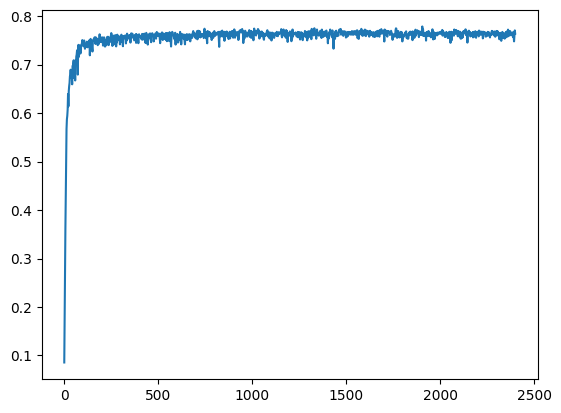

In [64]:
plt.plot(np.arange(0,2*len(np.array(metrics['test_Mean_Dice'])),2),np.array(metrics['test_Mean_Dice']))
print(len(np.array(metrics['test_Mean_Dice'])))


1200
1076


0.769995391368866

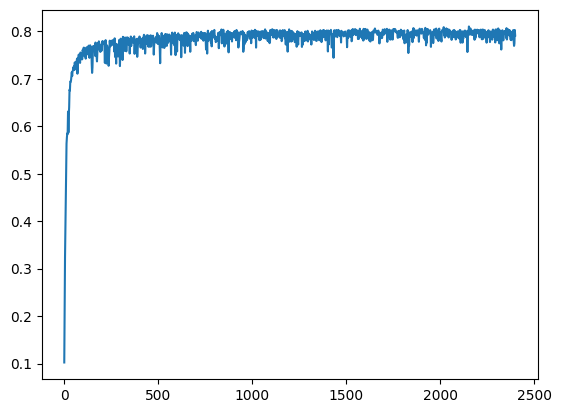

In [65]:
plt.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),np.array(metrics['Val_Mean_Dice']))
print(len(np.array(metrics['Val_Mean_Dice'])))
print(np.argmax(np.array(metrics['Val_Mean_Dice'])))
np.array(metrics['test_Mean_Dice'])[np.argmax(np.array(metrics['Val_Mean_Dice']))]

In [21]:
metrics

,Unnamed: 0,Val_Mean_Dice,test_Mean_Dice,boundary_detection_dice,boundary_detection_dice_test,boundary_difference_dice,boundary_difference_dice_test
0,0,0.102483,0.085540,0.090852,0.083503,0.842854,0.866464
1,1,0.211029,0.183247,0.071451,0.073658,0.874896,0.869310
2,2,0.323835,0.300627,0.093913,0.092753,0.877011,0.873141
3,3,0.384006,0.361030,0.093814,0.082621,0.871040,0.868592
4,4,0.438375,0.430225,0.091267,0.093056,0.908258,0.861348
...,...,...,...,...,...,...,...
1195,1195,0.780330,0.757670,0.241860,0.230846,0.916694,0.926587
1196,1196,0.769165,0.747989,0.229573,0.220102,0.932483,0.936762
1197,1197,0.773951,0.758834,0.235082,0.222206,0.931224,0.949406
1198,1198,0.802527,0.770605,0.207655,0.218610,0.952179,0.943821


In [22]:
np.mean(np.array(metrics['test_Mean_Dice'])[-100:])

0.7630149084329605

100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


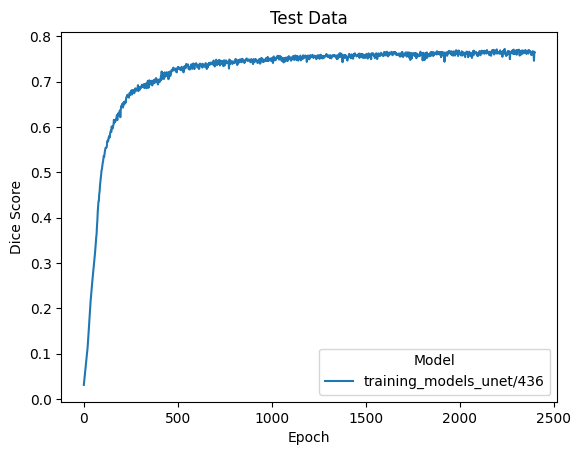

In [23]:
plt.style.use('default')
for file in tqdm(folders[2:3]):
    metrics = pd.read_excel(file)
    plt.plot(np.arange(0,2400,2),
             np.array(metrics['test_Mean_Dice']),
             label = re.sub('training_models/','',re.sub('/metrics_validation_rerun.xlsx','',file)))
plt.legend(title='Model')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Test Data')
plt.savefig('436_test.png')

100%|██████████| 4/4 [00:00<00:00,  9.39it/s]


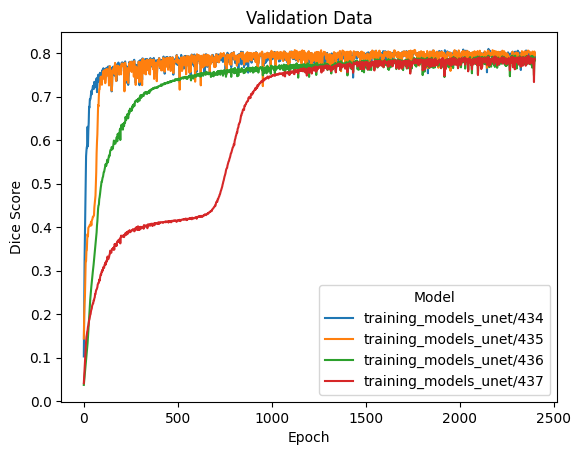

In [24]:
for file in tqdm(folders[:4]):
    metrics = pd.read_excel(file)
    plt.plot(np.arange(0,2400,2),
             np.array(metrics['Val_Mean_Dice']),
             label = re.sub('training_models/','',re.sub('/metrics_validation_rerun.xlsx','',file)))
plt.legend(title='Model')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Validation Data')
plt.savefig('434-437_val.png')

# Hyperparameter optimization

## UNETR

In [25]:
runs = np.arange(362,434,1)
runs = runs.astype('str')
runs

array(['362', '363', '364', '365', '366', '367', '368', '369', '370',
       '371', '372', '373', '374', '375', '376', '377', '378', '379',
       '380', '381', '382', '383', '384', '385', '386', '387', '388',
       '389', '390', '391', '392', '393', '394', '395', '396', '397',
       '398', '399', '400', '401', '402', '403', '404', '405', '406',
       '407', '408', '409', '410', '411', '412', '413', '414', '415',
       '416', '417', '418', '419', '420', '421', '422', '423', '424',
       '425', '426', '427', '428', '429', '430', '431', '432', '433'],
      dtype='<U21')

In [26]:
dirc = Path('training_models/')
folders = list(dirc.glob('*/metrics_validation.csv'))
folders = sorted([x.as_posix() for x in folders])
folders = [x for x in folders if re.sub('training_models/','',re.sub('/metrics_validation.csv','',x)) in runs]

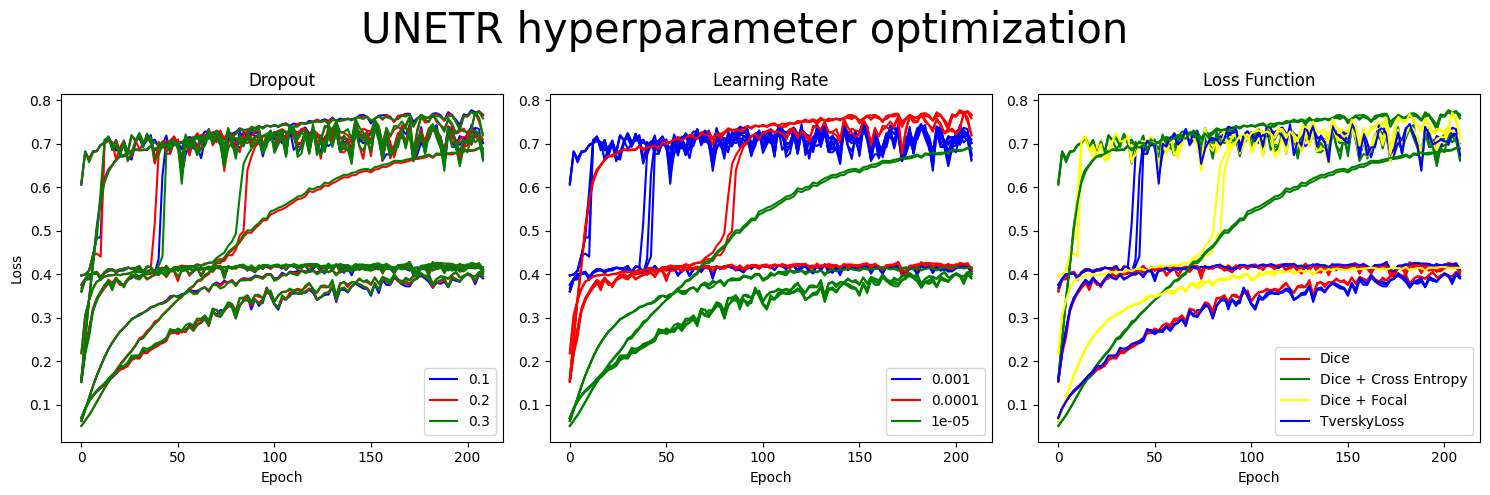

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
res = []
for file in folders:
    parameter_file = 'hyperparameter_pickle_files/parameters' + re.sub('training_models/','',re.sub('/metrics_validation.csv','',file)) + '.pickle'
    with open(parameter_file, 'rb') as handle:
        params = pickle.load(handle)
    if params['norm'] == 'INSTANCE':
        metrics = pd.read_csv(file)
        res.append(np.max(metrics['Val_Mean_Dice']))
        if params['dropout'] == 0.1:
            ax1.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'blue')
        elif params['dropout'] == 0.2:
            ax1.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'red')
        elif params['dropout'] == 0.3:
            ax1.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'green')
        else:
            break
        if params['learning_rate'] == 1e-3:
            ax2.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'blue')
        elif params['learning_rate'] == 1e-4:
            ax2.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'red')
        elif params['learning_rate'] == 1e-5:
            ax2.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'green')
        else:
            break
        if str(params['loss_function']) == 'TverskyLoss()':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'TverskyLoss',
                     color = 'blue')
        elif str(params['loss_function']) == 'DiceLoss()':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice',
                     color = 'red')
        elif str(params['loss_function']) == 'DiceCELoss(\n  (dice): DiceLoss()\n  (cross_entropy): CrossEntropyLoss()\n)':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Cross Entropy',
                     color = 'green')
        elif str(params['loss_function']) == 'DiceFocalLoss(\n  (dice): DiceLoss()\n  (focal): FocalLoss()\n)':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Focal',
                     color = 'Yellow')
        else:
            break
plt.sca(ax1)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax1.legend(newHandles, newLabels)
plt.sca(ax2)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax2.legend(newHandles, newLabels)
plt.sca(ax3)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax3.legend(newHandles, newLabels)
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax3.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Dropout')
ax2.set_title('Learning Rate')
ax3.set_title('Loss Function')
fig.suptitle('UNETR hyperparameter optimization', fontsize=30)
fig.tight_layout()
fig.savefig('UNETR_optim_short.png')

In [29]:
max(res)

0.7767901420593262

## Unet

In [41]:
runs = np.arange(1,289,1)
runs = runs.astype('str')

In [42]:
dirc = Path('training_models/')
folders = list(dirc.glob('*/metrics_validation.csv'))
folders = sorted([x.as_posix() for x in folders])
folders = [x for x in folders if re.sub('training_models/','',re.sub('/metrics_validation.csv','',x)) in runs]

100%|██████████| 153/153 [00:00<00:00, 615.38it/s]


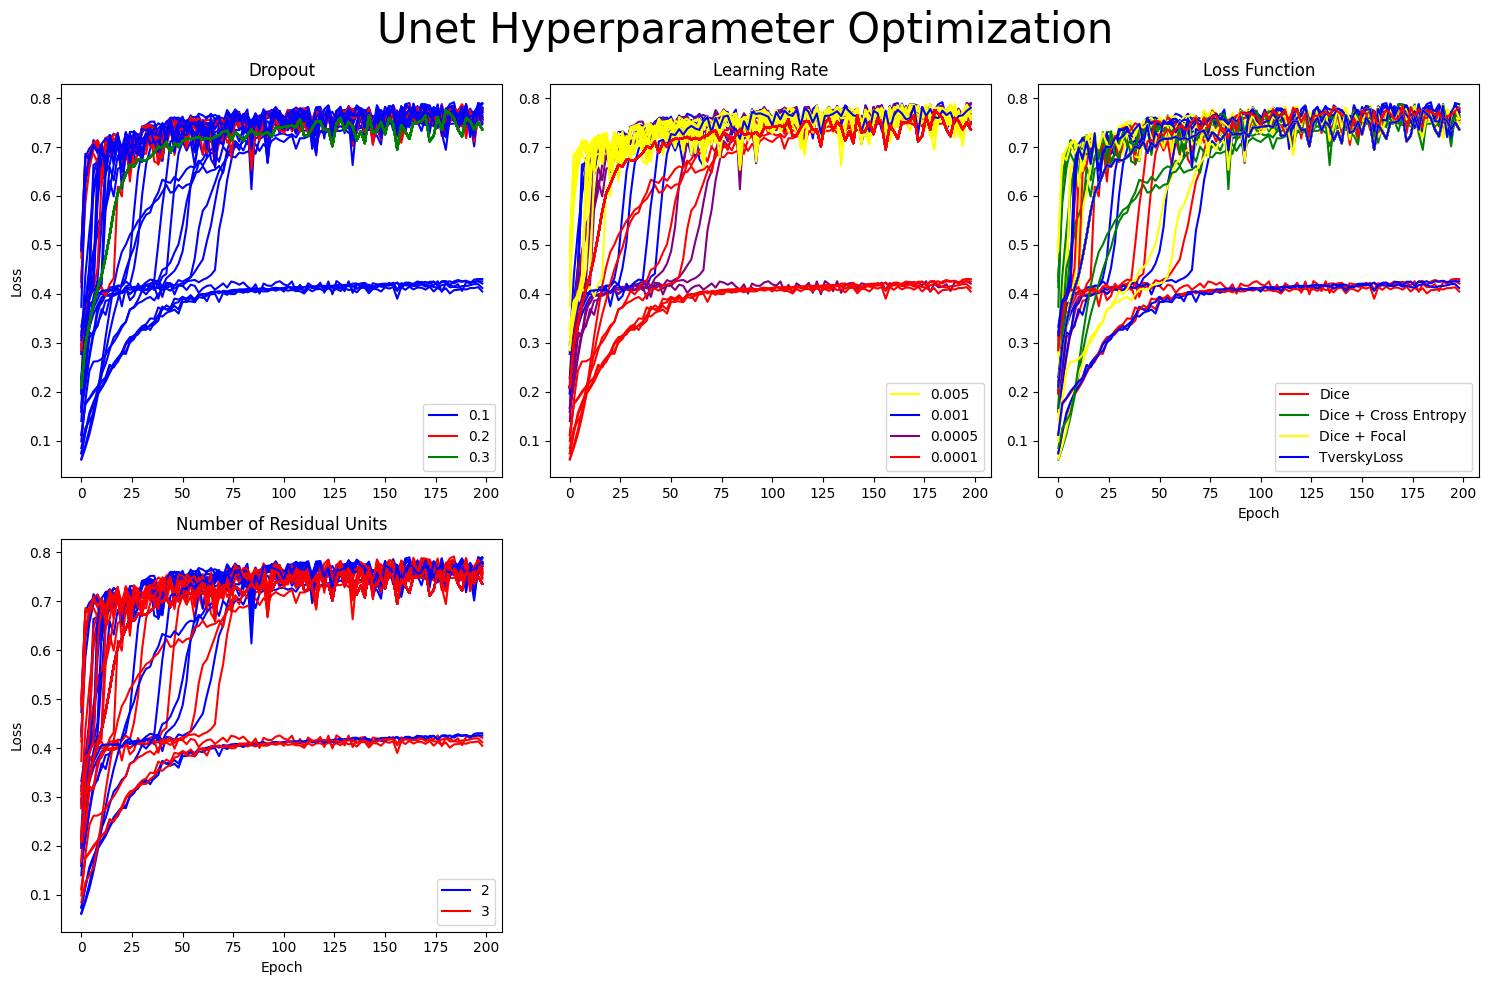

In [53]:
fig, ax = plt.subplots(2,3,figsize=(15, 10))
res = []
for file in tqdm(folders):
    parameter_file = 'hyperparameter_pickle_files/parameters' + re.sub('training_models/','',re.sub('/metrics_validation.csv','',file)) + '.pickle'
    with open(parameter_file, 'rb') as handle:
        params = pickle.load(handle)
    metrics = pd.read_csv(file)
    if 'Val_Mean_Dice' in metrics.keys() and str(params['norm']) != 'BATCH':
        if params['dropout'] == 0.1:
            ax[0,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'blue')
            res.append(np.max(metrics['Val_Mean_Dice']))
        elif params['dropout'] == 0.2:
            ax[0,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'red')
            res.append(np.max(metrics['Val_Mean_Dice']))
        elif params['dropout'] == 0.3:
            ax[0,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'green')
            res.append(np.max(metrics['Val_Mean_Dice']))
        else:
            print(params['dropout'])
            break
        if params['learning_rate'] == 1e-3:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'blue')
        elif params['learning_rate'] == 1e-4:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'red')
        elif params['learning_rate'] == 5e-4:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'purple')
        elif params['learning_rate'] == 5e-3:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'yellow')
        elif params['learning_rate'] == 1e-5:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'green')
        else:
            print(params['learning_rate'])
            break
        if str(params['loss_function']) == 'TverskyLoss()':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'TverskyLoss',
                     color = 'blue')
        elif str(params['loss_function']) == 'DiceLoss()':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice',
                     color = 'red')
        elif str(params['loss_function']) == 'DiceCELoss(\n  (dice): DiceLoss()\n  (cross_entropy): CrossEntropyLoss()\n)':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Cross Entropy',
                     color = 'green')
        elif str(params['loss_function']) == 'DiceFocalLoss(\n  (dice): DiceLoss()\n  (focal): FocalLoss()\n)':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Focal',
                     color = 'Yellow')
        else:
            print(str(params['loss_function']))
            break
        #if str(params['norm']) == 'INSTANCE':
        #    ax[1,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
        #             np.array(metrics['Val_Mean_Dice']),
        #             label = 'Instance',
        #             color = 'blue')
        #elif str(params['norm']) == 'BATCH':
        #    ax[1,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
        #             np.array(metrics['Val_Mean_Dice']),
        #             label = 'Batch',
        #             color = 'red')
        #else:
        #    print(params['norm'])
        #    break
        if params['num_res_units'] == 2:
            ax[1,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 2,
                     color = 'blue')
        elif params['num_res_units'] == 3:
            ax[1,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 3,
                     color = 'red')
        else:
            print(params['num_res_units'])
            break
plt.sca(ax[0,0])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0,0].legend(newHandles, newLabels)
plt.sca(ax[0,1])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0,1].legend(newHandles, newLabels)
plt.sca(ax[0,2])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0,2].legend(newHandles, newLabels)
#plt.sca(ax[1,0])
#handles, labels = plt.gca().get_legend_handles_labels()
#newLabels, newHandles = [], []
#for handle, label in zip(handles, labels):
#    if label not in newLabels:
#        newLabels.append(label)
#        newHandles.append(handle)
#ax[1,0].legend(newHandles, newLabels)
plt.sca(ax[1,0])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[1,0].legend(newHandles, newLabels)

ax[1,0].set_xlabel('Epoch')
#ax[1,1].set_xlabel('Epoch')
ax[0,2].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[1,0].set_ylabel('Loss')
ax[0,0].set_title('Dropout')
ax[0,1].set_title('Learning Rate')
ax[0,2].set_title('Loss Function')
#ax[1,0].set_title('Normilization')
ax[1,0].set_title('Number of Residual Units')
fig.delaxes(ax[1,2])
fig.delaxes(ax[1,1])
fig.suptitle('Unet Hyperparameter Optimization', fontsize=30)
fig.tight_layout()
fig.savefig('unet_optim_short.png')

In [40]:
np.max(res)

0.7916300892829895

In [17]:
'Val_Mean_Dice' in metrics.keys()

True

In [18]:
metrics.keys()

Index(['Unnamed: 0', 'Val_Mean_Dice', 'boundary_detection_dice',
       'boundary_difference_dice'],
      dtype='object')

In [45]:
params

{'crop_size': (128, 128, 128),
 'N_crops': 6,
 'optimizer': torch.optim.adam.Adam,
 'batch_size': 2,
 'max_epochs': 200,
 'intensity_transform_probability': 0.5,
 'gaussian_transform_probability': 0.5,
 'rotation_flip_transforms_probability': 0.5,
 'deformation_transforms_prob': 0.5,
 'Rand3DElasticd_sigma_range': (1, 2),
 'Rand3DElasticd_magnitude_range': (3, 10),
 'RandGridDistortiond_num_cells': 8,
 'RandGridDistortiond_distort_limit': (-0.03, 0.03),
 'RandShiftIntensityd_offsets': 0.3,
 'RandAdjustContrastd_gamma': (0.5, 4.5),
 'RandHistogramShiftd_num_control_points': 4,
 'RandGaussianNoised_mean': 0,
 'RandGaussianNoised_std': 0.1,
 'RandomAffine_probability': 0.4,
 'RandomAffine_degrees': (30, 30, 30),
 'RandomAffine_scales': (0.1, 0.1, 0.1),
 'RandomAffine_translation': (0.1, 0.1, 0.1),
 'norm': 'INSTANCE',
 'dropout': 0.1,
 'learning_rate': 0.005,
 'num_res_units': 2,
 'loss_function': DiceLoss()}